In [1]:
import pandas as pd
import json
import re
import requests
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt

# Primogem Economy & Propensity to Save

Players consistently use fewer primogems than they are supplied, and newly granted primogems typically take around five days to be spent. This suggests that most players deliberately save their currency rather than spending it immediately. For example, primogems awarded at the start of a new patch, usually on Wednesdays, are largely stockpiled for future banners or events.

We show this through 1) comparison of primogem used vs supplied and 2) analysis of the lag between when primogems are granted and when they are actually spent.

In [30]:
events_df = pd.read_csv('data/primogem_events.csv')
events_df['Date'] = pd.to_datetime(events_df['Date'])

start_cutoff = pd.Timestamp('2022-09-22')
end_cutoff = pd.Timestamp('2025-10-22')
events_df = events_df[(events_df['Date'] >= start_cutoff) & (events_df['Date'] <= end_cutoff)]
primogem_supply_df = events_df.groupby('Date')['Primogems'].sum().reset_index()
primogem_supply_df.rename(columns={'Primogems':'Primogem Supplied'}, inplace=True)

primogem_supply_df

,Date,Primogem Supplied
0,2022-09-27,1160
1,2022-09-28,460
2,2022-09-29,720
3,2022-09-30,400
4,2022-10-01,20
...,...,...
692,2025-10-13,70
693,2025-10-14,70
694,2025-10-15,70
695,2025-10-17,20


In [31]:
is_banner_day = events_df['Event'].str.contains(r'Trial.*\/|\/.*Trial', regex=True, na=False)
banner_days = events_df[is_banner_day]['Date'].to_list()


In [32]:
filepath = 'data/primogem_used.csv'
if os.path.exists(filepath):
    primogem_used_df = pd.read_csv(filepath)
    primogem_used_df['Date'] = pd.to_datetime(primogem_used_df['Date'])
else:
    date_data = {}  # key: day, value: dict with wishes and users

    for banner_id in range(36, 90):
        url = f'https://api.paimon.moe/wish?banner=3000{banner_id}'
        response = requests.get(url).json()
        
        total_wishes = response['total']['all']
        total_users = response['total']['users']
        
        for entry in response['pullByDay']:
            day = entry['day'][:10]  # extract YYYY-MM-DD
            percentage = entry['percentage']
            day_wishes = percentage * total_wishes
            
            # Store both wishes and users
            date_data[day] = {
                'Primogem Used': day_wishes,
                'Total Users': total_users
            }
    primogem_used_df = pd.DataFrame.from_dict(date_data, orient='index').reset_index()
    primogem_used_df = primogem_used_df.rename(columns={'index': 'Date'})
    # For some reason, it is one day off, so we correct that
    primogem_used_df['Date'] = pd.to_datetime(primogem_used_df['Date'])
    primogem_used_df['Date'] = primogem_used_df['Date'] + pd.Timedelta(days=1)

In [33]:
primogem_used_df['Average Used'] = primogem_used_df['Primogem Used'] / primogem_used_df['Total Users'] 

In [34]:
primogem_market_df = pd.merge(
    primogem_used_df,
    primogem_supply_df,
    on='Date',
    how='left'  # left join: keep all demand dates
).fillna(0)

# We know that from the start date to end date, our dataset has all possible dates
full_range = pd.date_range(
    start=primogem_market_df['Date'].min(),
    end=primogem_market_df['Date'].max()
)

missing_dates = full_range.difference(primogem_market_df['Date'])
print("Missing dates:", missing_dates)

# Save the primogem market csv
primogem_market_df.to_csv('data/primogem_market.csv', index=False)


Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [35]:
primogem_market_df

,Unnamed: 0,Date,Primogem Used,Total Users,Average Used,Primogem Supplied
0,0,2022-09-29,3.227008e+06,400786,8.051699,720.0
1,1,2022-09-30,2.654193e+06,400786,6.622470,400.0
2,2,2022-10-01,3.728094e+06,400786,9.301956,20.0
3,3,2022-10-02,1.685127e+06,400786,4.204556,300.0
4,4,2022-10-03,1.164769e+06,400786,2.906211,40.0
...,...,...,...,...,...,...
1115,1115,2025-10-18,1.182633e+05,122449,0.965817,0.0
1116,1116,2025-10-19,1.136234e+05,122449,0.927924,0.0
1117,1117,2025-10-20,9.749493e+04,122449,0.796208,0.0
1118,1118,2025-10-21,3.874733e+04,122449,0.316436,1740.0


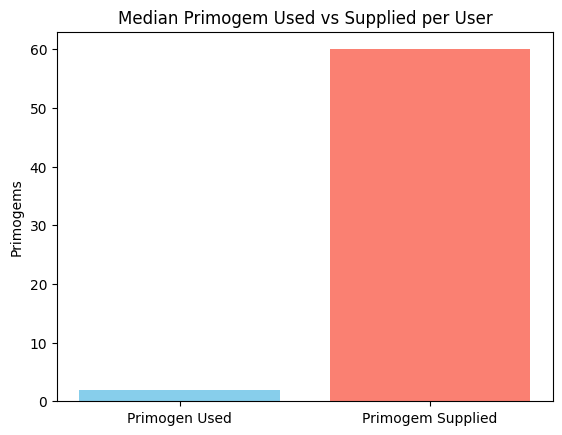

In [36]:
medians = primogem_market_df[['Average Used', 'Primogem Supplied']].median()

# Plot as a bar chart
plt.bar(medians.index, medians.values, color=['skyblue', 'salmon'])
plt.ylabel('Primogems')
plt.xticks(ticks=[0, 1], labels=['Primogen Used', 'Primogem Supplied'])
plt.title('Median Primogem Used vs Supplied per User')
plt.show()


## Primogem usage shows only a weak correlation with the timing of when they are supplied, indicating delayed or stockpiled spending.

In [37]:
primogem_lags_df = primogem_market_df.copy()
for lag in range(1, 6):  # 1–5 day lags
    primogem_lags_df[f'Primogem Supplied Lag {lag}'] = primogem_lags_df['Primogem Supplied'].shift(lag).fillna(0)

Text(0.5, 1.0, 'Correlation Matrix for the Primogems\n(In-Game Currency) Market')

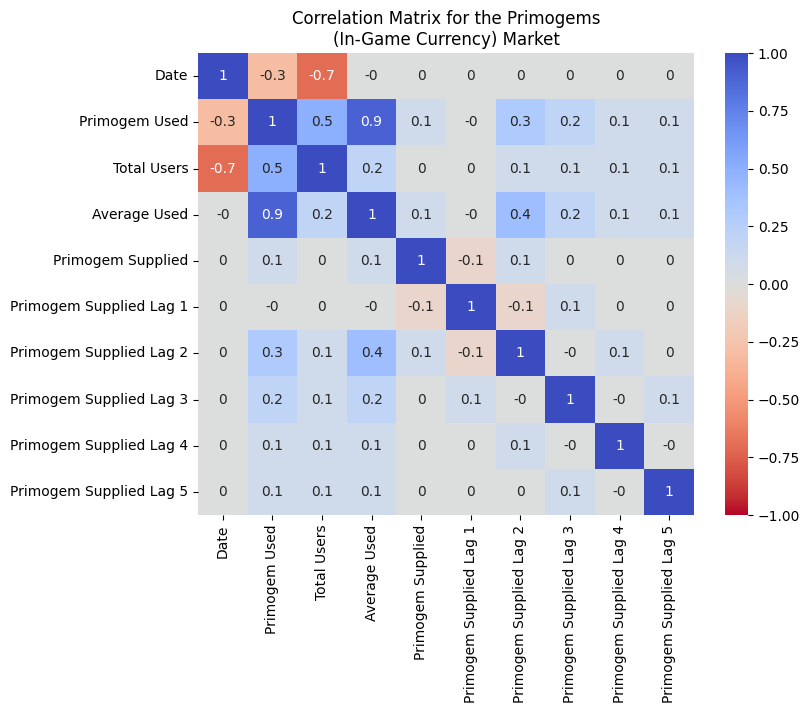

In [38]:
plt.figure(figsize=(8, 6))

sns.heatmap(data=primogem_lags_df.iloc[:, 1:].corr().round(1),
            cmap='coolwarm_r',
            vmin=-1,
            vmax=1,
            annot=True);

plt.title('Correlation Matrix for the Primogems\n(In-Game Currency) Market')

# Banner event analysis - The average change in the number of primogems used before and after a banner is launched is +1.64%

Even though players tend to stockpile primogems and there’s a lag in spending, banner events still create a measurable spike in usage. The +1.64% increase shows that some stockpiled primogems are actually spent in response to banner launches.

In [39]:
window = 5 # days before and after the banner
results = []

for bd in banner_days:
    # Pre-banner wishes
    pre_wishes = primogem_market_df[
        (primogem_market_df['Date'] >= bd - pd.Timedelta(days=window)) & 
        (primogem_market_df['Date'] < bd)
    ]['Primogem Used'].sum()
    
    # Post-banner wishes
    post_wishes = primogem_market_df[
        (primogem_market_df['Date'] > bd) & 
        (primogem_market_df['Date'] <= bd + pd.Timedelta(days=window))
    ]['Primogem Used'].sum()
    
    # Compute relative change safely
    if pre_wishes == 0:
        rel_change = None  # or you could set it to np.nan
    else:
        rel_change = (post_wishes - pre_wishes) / pre_wishes
    
    results.append({
        'Banner Day': bd,
        'Pre-Wishes': pre_wishes,
        'Post-Wishes': post_wishes,
        'Absolute Change': post_wishes - pre_wishes,
        'Relative Change': rel_change
    })

banner_wish_df = pd.DataFrame(results)


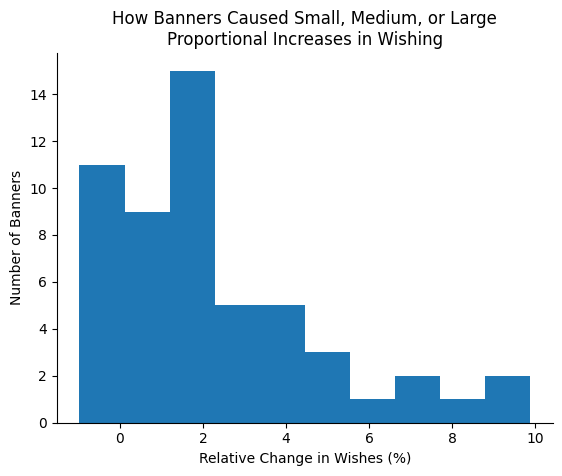

In [40]:
banner_wish_df['Relative Change'].hist()
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Relative Change in Wishes (%)')
plt.ylabel('Number of Banners')
plt.title('How Banners Caused Small, Medium, or Large\nProportional Increases in Wishing')
plt.show()


# Average path cycle analysis

Analysis of the patch cycle shows that primogem demand spikes toward the end of a banner. This behavior is driven by FOMO (fear of missing out), as players rush to spend their stockpiled primogems before the banner expires.

In [41]:
patch_comp_events = events_df[events_df['Event'].str.contains('Patch Compensation', case=False, na=False)]

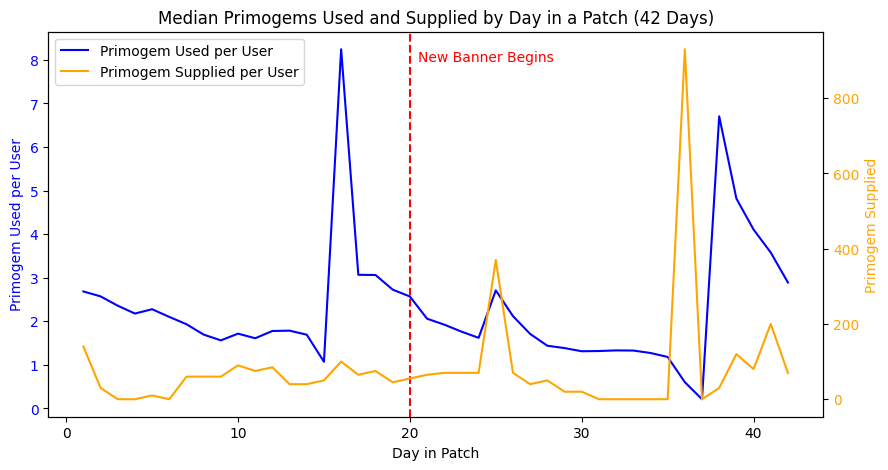

In [43]:
primogem_market_df['Day_in_Patch'] = np.nan
start_idx = 33

# Number of rows from start_idx to the end
n_rows = len(primogem_market_df) - start_idx

# Create a repeating counter from 1 to 42
counter = [(i % 42) + 1 for i in range(n_rows)]

# Assign it
primogem_market_df.loc[start_idx:, 'Day_in_Patch'] = counter

median_df = primogem_market_df.groupby('Day_in_Patch')[['Average Used', 'Primogem Supplied']].median()

fig, ax1 = plt.subplots(figsize=(10,5))

# Plot Primogem Used on left y-axis
ax1.plot(median_df.index, median_df['Average Used'], color='blue', label='Primogem Used per User')
ax1.set_xlabel('Day in Patch')
ax1.set_ylabel('Primogem Used per User', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for Primogem Supplied
ax2 = ax1.twinx()
ax2.plot(median_df.index, median_df['Primogem Supplied'], color='orange', label='Primogem Supplied per User')
ax2.set_ylabel('Primogem Supplied', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add vertical line at Day 20
ax1.axvline(x=20, color='red', linestyle='--', linewidth=1.5)
ax1.text(20 + 0.5, ax1.get_ylim()[1]*0.95, 'New Banner Begins', rotation=0, color='red', va='top')


# Optional: add title
plt.title('Median Primogems Used and Supplied by Day in a Patch (42 Days)')

# Optional: combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()
